In [4]:
import os
import sys
import time
import copy
import random
import argparse

from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter


import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import PIL

import matplotlib
from mpl_toolkits import mplot3d
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import seaborn as sns

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report

from tqdm import tqdm

sys.path.append("../src/expB/")
from spheres_v2 import RandomSphere
from ptcifar.models import *
from learn_mfld_distance import train, test
from myNNs import *

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)



# Contents

- [For line embedded in 2D](#For-line-embedded-in-2D)
- [For line embedded in 3D](#For-line-embedded-in-3D)
- [For a circle in 2D](#For-a-circle-in-2D)
- [For a circle genrated by `RandomSphere` in unit square](#For-a-circle-genrated-by-RandomSphere-in-unit-square)
- [For a two circles genrated by `TwoRandomSpheres` in unit square](#For-a-two-circles-genrated-by-TwoRandomSpheres-in-unit-square)


device(type='cuda', index=1)

# For line embedded in 2D

In [ ]:
def line2D(x, y, a=1, b=-1, c=0, signed=False):
    """returns distance from line ax + by + c = 0"""
    
    dist = (a * x + b * y + c) / (a^2 + b^2)**(0.5)
    if signed:
        return dist
    else:
        return np.abs(dist)
    
def gen_line2D(a=1, b=-1, c=0, n=50):
    x = np.linspace(0, 1, n)
    
    y = (-c - (a * x)) / b
    
    return x, y



x, y = gen_line2D()



In [ ]:
NUM_TRAIN = 50000
NUM_VAL = 10000





In [ ]:
np.hstack((np.ones((2)), np.zeros((2))))




In [ ]:
train_points = np.random.uniform(size=(NUM_TRAIN//2, 2))
train_distances = line2D(train_points[:, 0], train_points[:, 1])
on_line_x, on_line_y = gen_line2D(n=NUM_TRAIN//2)
on_line = np.zeros((NUM_TRAIN//2, 2))
on_line[:, 0], on_line[:, 1] = on_line_x, on_line_y
train_points = np.vstack((train_points, on_line))
train_distances = np.hstack((train_distances, np.zeros(NUM_TRAIN//2))).reshape(-1, 1)


val_points = np.random.uniform(size=(NUM_VAL//2, 2))
val_distances = line2D(val_points[:, 0], val_points[:, 1])
on_line_x, on_line_y = gen_line2D(n=NUM_VAL//2)
on_line = np.zeros((NUM_VAL//2, 2))
on_line[:, 0], on_line[:, 1] = on_line_x, on_line_y
val_points = np.vstack((val_points, on_line))
val_distances = np.hstack((val_distances, np.zeros(NUM_VAL//2))).reshape(-1, 1)


In [ ]:
plt.scatter(train_points[:, 0], train_points[:, 1], s=0.1)
# plt.plot(x, y, '*-', c="red")
plt.show()




In [ ]:
train_points = torch.from_numpy(train_points).float()
train_distances = torch.from_numpy(train_distances).float()


val_points = torch.from_numpy(val_points).float()
val_distances = torch.from_numpy(val_distances).float()


In [ ]:
train_dataset = TensorDataset(train_points, train_distances)
val_dataset = TensorDataset(val_points, val_distances)

train_dl = DataLoader(train_dataset, num_workers=True, shuffle=True, batch_size=512)
val_dl = DataLoader(val_dataset, num_workers=True, shuffle=True, batch_size=512)

dataloaders = {
    "train": train_dl,
    "val": val_dl
}


device = torch.device("cuda:0")
model = MLP(input_size=2, output_size=1, use_tanh=False)

loss_func = nn.MSELoss()

LEARNING_RATE = 1e-5
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

NUM_EPOCHS = 500
scheduler_params = {"warmup": 10, "cooldown": 250}
lr_sched_factor = lambda epoch: epoch / (scheduler_params["warmup"]) if epoch <= scheduler_params["warmup"] else (1 if epoch > scheduler_params["warmup"] and epoch < scheduler_params["cooldown"] else max(0, 1 + (1 / (scheduler_params["cooldown"] - NUM_EPOCHS)) * (epoch - scheduler_params["cooldown"])))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_sched_factor)

NAME = "MLP_Line_model{hidden_sizes=512x4}"
SAVE_DIR = "/azuredrive/dumps/expB_learning_distance_from_mfld/"

task = "regression"



In [ ]:
model, optimizer, train_loss_matrix, val_loss_matrix = train(model=model, optimizer=optimizer, loss_func=loss_func, dataloaders=dataloaders,\
                 device=device, task=task,num_epochs=NUM_EPOCHS, save_dir=SAVE_DIR,\
                 name=NAME, scheduler=scheduler, scheduler_params=scheduler_params)



In [ ]:
# ! rm -rf /azuredrive/dumps/expB_learning_distance_from_mfld/MLP_Line_model\{hidden_sizes\=512x4\}

# For line embedded in 3D

In [ ]:
def line3D(c, a=np.array([1, 1, 1]), b=np.array([0,0,0])):
    """returns distance from line with end points at `a` and `b`"""
    
    t = np.dot((c - a), (b - a)) / (np.linalg.norm(b - a, ord=2) ** 2)
    x = a + t.reshape(-1, 1) * (b - a)
    return np.linalg.norm(c - x, ord=2, axis=1)
    

def gen_line3D(a=np.array([1, 1, 1]), b=np.array([0,0,0]), n=50):
    
    x = np.linspace(0, 1, n)
    
    y = ((x - a[0]) / (b[0] - a[0])) * (b[1] - a[1]) + a[1]
    
    z = ((x - a[0]) / (b[0] - a[0])) * (b[2] - a[2]) + a[2]
    
    return x, y, z



In [ ]:
x, y, z = gen_line3D()

NUM_TRAIN = 50000
NUM_VAL = 10000


train_points = np.random.uniform(size=(NUM_TRAIN//2, 3))
train_distances = line3D(train_points)
on_line_x, on_line_y, on_line_z = gen_line3D(n=NUM_TRAIN//2)
on_line = np.zeros((NUM_TRAIN//2, 3))
on_line[:, 0], on_line[:, 1], on_line[:, 2] = on_line_x, on_line_y, on_line_z
train_points = np.vstack((train_points, on_line))
train_distances = np.hstack((train_distances, np.zeros(NUM_TRAIN//2))).reshape(-1, 1)


val_points = np.random.uniform(size=(NUM_VAL//2, 3))
val_distances = line3D(val_points)
on_line_x, on_line_y, on_line_z = gen_line3D(n=NUM_VAL//2)
on_line = np.zeros((NUM_VAL//2, 3))
on_line[:, 0], on_line[:, 1], on_line[:, 2] = on_line_x, on_line_y, on_line_z
val_points = np.vstack((val_points, on_line))
val_distances = np.hstack((val_distances, np.zeros(NUM_VAL//2))).reshape(-1, 1)



train_points = torch.from_numpy(train_points).float()
train_distances = torch.from_numpy(train_distances).float()
val_points = torch.from_numpy(val_points).float()
val_distances = torch.from_numpy(val_distances).float()


fig = plt.figure(figsize = (10, 7))
ax1 = plt.axes(projection ="3d")
ax1.scatter3D(train_points[:, 0], train_points[:, 1], train_points[:, 2], s=0.1)
# plt.plot(x, y, '*-', c="red")
plt.show()

In [ ]:
train_dataset = TensorDataset(train_points, train_distances)
val_dataset = TensorDataset(val_points, val_distances)

train_dl = DataLoader(train_dataset, num_workers=True, shuffle=True, batch_size=512)
val_dl = DataLoader(val_dataset, num_workers=True, shuffle=True, batch_size=512)

dataloaders = {
    "train": train_dl,
    "val": val_dl
}


device = torch.device("cuda:0")
model = MLP(input_size=3, output_size=1, use_tanh=False)

loss_func = nn.MSELoss()

LEARNING_RATE = 1e-5
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

NUM_EPOCHS = 500
scheduler_params = {"warmup": 10, "cooldown": 250}
lr_sched_factor = lambda epoch: epoch / (scheduler_params["warmup"]) if epoch <= scheduler_params["warmup"] else (1 if epoch > scheduler_params["warmup"] and epoch < scheduler_params["cooldown"] else max(0, 1 + (1 / (scheduler_params["cooldown"] - NUM_EPOCHS)) * (epoch - scheduler_params["cooldown"])))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_sched_factor)

NAME = "MLP_Line3D_model{hidden_sizes=512x4}"
SAVE_DIR = "/azuredrive/dumps/expB_learning_distance_from_mfld/"

task = "regression"



In [ ]:
model, optimizer, train_loss_matrix, val_loss_matrix = train(model=model, optimizer=optimizer, loss_func=loss_func, dataloaders=dataloaders,\
                 device=device, task=task,num_epochs=NUM_EPOCHS, save_dir=SAVE_DIR,\
                 name=NAME, scheduler=scheduler, scheduler_params=scheduler_params)



# For a circle in 2D





In [ ]:
def circle2D(x, c=np.array([0.5, 0.5]), r=0.4):
    """returns distance of a point from a circle"""
    return np.abs(np.linalg.norm(x - c, ord=2, axis=1) - r)

def gen_circle2D(c=np.array([0.5, 0.5]), r=0.4, n=50000):
    """returns points on a circle"""
    
    points = np.random.normal(size=(n, 2))
    points = (r * (points - c) / np.linalg.norm(points - c, ord=2, axis=1).reshape(-1, 1)) + c
    
    return points[:, 0], points[:, 1]

In [ ]:
NUM_TRAIN = 1000000
NUM_VAL = 500000


train_points = np.random.uniform(low=-1000, high=1000, size=(NUM_TRAIN//2, 2))
train_distances = circle2D(train_points, r=250, c=np.array([0, 0]))
on_line_x, on_line_y = gen_circle2D(r=250, c=np.array([0, 0]) ,n=NUM_TRAIN//2)
on_line = np.zeros((NUM_TRAIN//2, 2))
on_line[:, 0], on_line[:, 1] = on_line_x, on_line_y
train_points = np.vstack((train_points, on_line))
train_distances = np.hstack((train_distances, np.zeros(NUM_TRAIN//2))).reshape(-1, 1)

max_distance = np.max(train_distances)
train_distances_norm = train_distances / max_distance
train_points_norm = train_points / max_distance


val_points = np.random.uniform(low=-1000, high=1000, size=(NUM_VAL//2, 2))
val_distances = circle2D(val_points, r=250, c=np.array([0, 0]))
on_line_x, on_line_y = gen_circle2D(r=250, c=np.array([0, 0]), n=NUM_VAL//2)
on_line = np.zeros((NUM_VAL//2, 2))
on_line[:, 0], on_line[:, 1] = on_line_x, on_line_y
val_points = np.vstack((val_points, on_line))
val_distances = np.hstack((val_distances, np.zeros(NUM_VAL//2))).reshape(-1, 1)

val_distances_norm = val_distances / max_distance
val_points_norm = val_points / max_distance


train_points = torch.from_numpy(train_points).float()
train_points_norm = torch.from_numpy(train_points_norm).float()
train_distances = torch.from_numpy(train_distances).float()
train_distances_norm = torch.from_numpy(train_distances_norm).float()


val_points = torch.from_numpy(val_points).float()
val_points_norm = torch.from_numpy(val_points_norm).float()
val_distances = torch.from_numpy(val_distances).float()
val_distances_norm = torch.from_numpy(val_distances_norm).float()

# fig = plt.figure(figsize = (10, 7))
# ax1 = plt.axes(projection ="3d")
# ax1.scatter3D(train_points[:, 0], train_points[:, 1], train_points[:, 2], s=0.1)
# plt.plot(x, y, '*-', c="red")
plt.scatter(train_points_norm[:, 0], train_points_norm[:, 1], s=0.001)
plt.show()
plt.scatter(val_points_norm[:, 0], val_points_norm[:, 1], s=0.001)

plt.show()

In [ ]:
train_points_norm[train_distances_norm.reshape(-1) == 0.0, 0].shape

In [ ]:
plt.scatter(train_points_norm[train_distances_norm.reshape(-1) < 0.01, 0], train_points_norm[train_distances_norm.reshape(-1) < 0.01, 1], s=0.001)
plt.show()
plt.scatter(val_points_norm[:, 0], val_points_norm[:, 1], s=0.001)

plt.show()

In [ ]:
train_dataset = TensorDataset(train_points_norm, train_distances_norm)
val_dataset = TensorDataset(val_points_norm, val_distances_norm)

train_dl = DataLoader(train_dataset, num_workers=True, shuffle=True, batch_size=512)
val_dl = DataLoader(val_dataset, num_workers=True, shuffle=True, batch_size=512)

dataloaders = {
    "train": train_dl,
    "val": val_dl
}


device = torch.device("cuda:0")
model = MLP(input_sizeinput_size=2, output_size=1, use_tanh=False, hidden_sizes=[512]*4)


loss_func = nn.MSELoss()

LEARNING_RATE = 1e-5
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

NUM_EPOCHS = 500
scheduler_params = {"warmup": 10, "cooldown": 250}
lr_sched_factor = lambda epoch: epoch / (scheduler_params["warmup"]) if epoch <= scheduler_params["warmup"] else (1 if epoch > scheduler_params["warmup"] and epoch < scheduler_params["cooldown"] else max(0, 1 + (1 / (scheduler_params["cooldown"] - NUM_EPOCHS)) * (epoch - scheduler_params["cooldown"])))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_sched_factor)

NAME = "MLP_Circle2D_model{hidden_sizes=512x4}"
SAVE_DIR = "/azuredrive/dumps/expB_learning_distance_from_mfld/"

task = "regression"



In [ ]:
model, optimizer, train_loss_matrix, val_loss_matrix = train(model=model, optimizer=optimizer, loss_func=loss_func, dataloaders=dataloaders,\
                 device=device, task=task,num_epochs=NUM_EPOCHS, save_dir=SAVE_DIR,\
                 name=NAME, scheduler=scheduler, scheduler_params=scheduler_params)



In [ ]:
# ! rm -rf /azuredrive/dumps/expB_learning_distance_from_mfld/MLP_Circle2D_model\{hidden_sizes\=512x4\}

# For a circle genrated by `RandomSphere` in unit square

In [ ]:
os.chdir("../src/expB/")



In [ ]:
# 3, 5, 10, 25, 50, 100, 1000

%run -i spheres_v2.py --config ./data_configs/sphere_in_unit_square_config_near_zero.json --save_dir /azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=3072,k=2,transformed,nearzero/
# %run -i spheres_v2.py --config ./data_configs/sphere_config.json --save_dir /azuredrive/datasets/expB/one_sphere/r=0.5,max_norm=0.25,D=0.2,n=3072,k=2,transformed,nearzero/


In [ ]:
plt.scatter(train_set.normed_points_n[:, 0], train_set.normed_points_n[:, 1], s=0.01)
plt.scatter(train_set.fix_center[0], train_set.fix_center[1])

In [ ]:
plt.hist(train_set.distances.reshape(-1).numpy())
plt.show()



In [ ]:
# fix_center = np.array([0.75] * train_set.n)

# train_set.points_n = (train_set.points_n - train_set.x_cn + fix_center).float()
# val_set.points_n = (val_set.points_n - val_set.x_cn + fix_center).float()



In [ ]:


train_dl = DataLoader(train_set, num_workers=True, shuffle=True, batch_size=512)
val_dl = DataLoader(val_set, num_workers=True, shuffle=True, batch_size=512)

dataloaders = {
    "train": train_dl,
    "val": val_dl
}


feature_name = "points_n"
target_name = "distances"

device = torch.device("cuda:0")
# model = MLP(input_size=train_set.points_n.shape[1], output_size=1, use_tanh=False, use_relu=False, hidden_sizes=[512]*4)
# model = MLPwithNormalisation(input_size=train_set.points_n.shape[1], output_size=1, weight_norm=False, use_tanh=False, use_relu=False, hidden_sizes=[1024]*2)
model = ResNet18(num_classes=1, use_sigmoid=False, use_tanh=False, use_relu=True)

loss_func = nn.MSELoss()

LEARNING_RATE = 1e-6
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

NUM_EPOCHS = 500
scheduler_params = {"warmup": 10, "cooldown": 300}
lr_sched_factor = lambda epoch: epoch / (scheduler_params["warmup"]) if epoch <= scheduler_params["warmup"] else (1 if epoch > scheduler_params["warmup"] and epoch < scheduler_params["cooldown"] else max(0, 1 + (1 / (scheduler_params["cooldown"] - NUM_EPOCHS)) * (epoch - scheduler_params["cooldown"])))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_sched_factor)

NAME = "test_CIFARResNet18_model{relu_last,lr=1e-6}_data{spheres_in_unit_cube;clamped;with_transforms;k=2;r=0.5;nearzero}"
SAVE_DIR = "/azuredrive/dumps/expB_learning_distance_from_mfld/"

task = "regression"



In [ ]:
model, optimizer, train_loss_matrix, val_loss_matrix = train(model=model, optimizer=optimizer, loss_func=loss_func, dataloaders=dataloaders,\
                 device=device, task=task,num_epochs=NUM_EPOCHS, save_dir=SAVE_DIR,\
                 name=NAME, scheduler=scheduler, scheduler_params=scheduler_params, feature_name=feature_name, target_name=target_name)



# For a two circles genrated by `TwoRandomSpheres` in unit square

In [2]:
os.chdir("../src/expB/")

In [3]:
%run -i spheres_v2.py --twospheres --config ./data_configs/2spheres_config.json --save_dir /azuredrive/datasets/expB/two_spheres/test_std_normal/



center generated
points generated
pre-images generated
[0. 1. 1. ... 0. 1. 0.]
embedding done
center generated
points generated
pre-images generated
[0. 0. 0. ... 1. 0. 1.]
embedding done
center generated
points generated
pre-images generated
[0. 0. 0. ... 1. 0. 0.]
embedding done
center generated
points generated
pre-images generated
[1. 0. 1. ... 0. 0. 0.]
embedding done
center generated
points generated
pre-images generated
[1. 1. 1. ... 0. 0. 0.]
embedding done
center generated
points generated
pre-images generated
[1. 0. 1. ... 0. 0. 0.]
embedding done


In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(train_set.normed_all_points[:, 0], train_set.normed_all_points[:, 1], s=0.001)
plt.show()

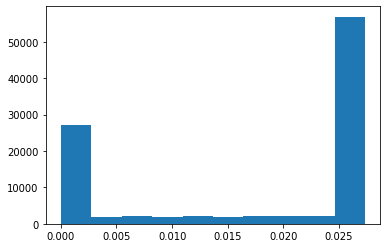

In [4]:
plt.hist(train_set.normed_all_distances[:, 0].numpy().reshape(-1))
plt.show()

In [5]:


train_dl = DataLoader(train_set, num_workers=True, shuffle=True, batch_size=512)
val_dl = DataLoader(val_set, num_workers=True, shuffle=True, batch_size=512)

dataloaders = {
    "train": train_dl,
    "val": val_dl
}


device = torch.device("cuda:0")
# model = MLP(input_size=train_set.normed_all_points.shape[1], output_size=2, use_tanh=False, use_relu=False, hidden_sizes=[512]*4)
model = MLPwithNormalisation(input_size=train_set.normed_all_points.shape[1], output_size=2, weight_norm=False, use_tanh=False, use_relu=False, hidden_sizes=[1024]*2)
# model = ResNet18(num_classes=1, use_sigmoid=True)

loss_func = nn.MSELoss()

LEARNING_RATE = 1e-5
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

NUM_EPOCHS = 500
scheduler_params = {"warmup": 10, "cooldown": 300}
lr_sched_factor = lambda epoch: epoch / (scheduler_params["warmup"]) if epoch <= scheduler_params["warmup"] else (1 if epoch > scheduler_params["warmup"] and epoch < scheduler_params["cooldown"] else max(0, 1 + (1 / (scheduler_params["cooldown"] - NUM_EPOCHS)) * (epoch - scheduler_params["cooldown"])))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_sched_factor)

NAME = "test_MLPwithNormalization_model{hidden_sizes=512x4,sigmoid_last,batch_norm}_data{2spheres_in_unit_cube;clamped;with_transforms;n=750;k=2;r=0.5;D=0.2;stdnormal;normalised}"
SAVE_DIR = "/azuredrive/dumps/expB_learning_distance_from_mfld/"

task = "regression"



In [6]:
model, optimizer, train_loss_matrix, val_loss_matrix = train(model=model, optimizer=optimizer, loss_func=loss_func, dataloaders=dataloaders,\
                 device=device, task=task,num_epochs=NUM_EPOCHS, save_dir=SAVE_DIR,\
                 name=NAME, scheduler=scheduler, scheduler_params=scheduler_params)



100%|██████████| 500/500 [41:30<00:00,  4.98s/it]


In [10]:
model.eval()

dataloader = val_dl

all_logits = None
all_distances = None
# all_true_distances = None
all_classes = None

with torch.no_grad():

    for batch in dataloader:
#         print(batch.keys())
        def get_data(batch_dict, feature_name="normed_points", target_name="normed_distances"):
            return batch_dict[feature_name], batch_dict[target_name]

        points, distances = get_data(batch)

        points = points.to(device)
        distances = distances.to(device)

        # points = batch[0].to(device)
        # distances = batch[1].to(device)
        # classes = batch[2].to(device)

        model.zero_grad()
        model = model.to(device)

        logits = model(points).detach().cpu()

        points = points.cpu()
        distances = distances.cpu()
        model = model.cpu()

        if all_logits is None:
            all_logits = logits
        else:
            all_logits = torch.cat((all_logits, logits))

        if all_distances is None:
            all_distances = distances
        else:
            all_distances = torch.cat((all_distances, distances))

        if task == "classification":
            if all_classes is None:
                all_classes = classes
            else:
                all_classes = torch.cat((all_classes, classes))


if task == "regression":
    mse = mean_squared_error(all_distances, all_logits)
    mse_on_mfld = mean_squared_error(all_distances[np.round(all_distances) == 0], all_logits[np.round(all_distances) == 0])



    print("MSE for the learned distances:", mse)
    print("MSE for the learned distances (on-manifold):", mse_on_mfld)

MSE for the learned distances: 5.3909833e-05
MSE for the learned distances (on-manifold): 5.391085e-05


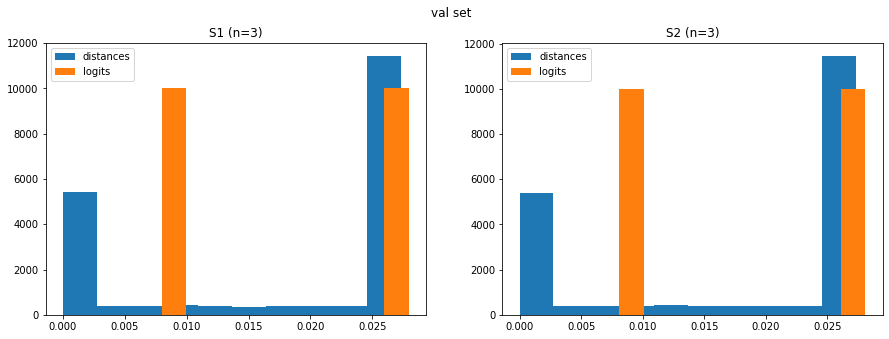

In [11]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(all_distances.shape[1]):
    axs[i].hist(all_distances[:,i].numpy().reshape(-1), label="distances")
    axs[i].hist(all_logits[:,i].numpy().reshape(-1), label="logits")
    axs[i].set_title("S{idx} (n=3)".format(idx=i+1))
    axs[i].legend()
    fig.suptitle("val set")
plt.show()

In [12]:
print("MSE on S1:", mean_squared_error(all_distances[:, 0], all_logits[:, 0]))
print("MSE on S2:", mean_squared_error(all_distances[:, 1], all_logits[:, 1]))


MSE on S1: 5.381208e-05
MSE on S2: 5.4009615e-05


In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(train_set.normed_all_points[:, 0], train_set.normed_all_points[:, 1], train_set.normed_all_points[:, 2], s=0.001)
ax.set_title("std-normal with radius 0.5 (normalised)")
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(train_set.all_points[:, 0], train_set.all_points[:, 1], train_set.all_points[:, 2], s=0.001)
ax.set_title("std-normal with radius 0.5")
plt.show()

In [ ]:
# ! rm -rf '/azuredrive/dumps/expB_learning_distance_from_mfld/test_MLP_model{hidden_sizes=512x4,sigmoid_last,lr=1e-6}_data{2spheres_in_unit_cube;clamped;with_transforms;k=2;r=0.5;normalised}'



In [ ]:
plt.hist(np.clip(np.abs(np.linalg.norm(train_set.normed_all_points[:train_set.S1.N] - train_set.S1.normed_x_cn, ord=2, axis=1) - (train_set.S1.r/train_set.norm_factor)), a_min=0, a_max=train_set.S1.D/train_set.norm_factor))





In [ ]:
plt.hist(train_set.normed_all_distances[:train_set.S1.N][:, 0].numpy())



In [ ]:
plt.scatter(train_set.normed_all_points[:train_set.S1.N][:, 0], train_set.normed_all_points[:train_set.S1.N][:, 1], s=0.01)
plt.scatter(train_set.S1.normed_x_cn[0], train_set.S1.normed_x_cn[1])


plt.scatter(train_set.normed_all_points[train_set.S1.N:][:, 0], train_set.normed_all_points[train_set.S1.N:][:, 1], s=0.01)
plt.scatter(train_set.shifted_S2.normed_x_cn[0], train_set.shifted_S2.normed_x_cn[1])

In [ ]:
plt.scatter(train_set.all_points[:train_set.S1.N][:, 0], train_set.all_points[:train_set.S1.N][:, 1], s=0.01)
plt.scatter(train_set.S1.x_cn[0], train_set.S1.x_cn[1])


plt.scatter(train_set.all_points[train_set.S1.N:][:, 0], train_set.all_points[train_set.S1.N:][:, 1], s=0.01)
plt.scatter(train_set.shifted_S2.x_cn[0], train_set.shifted_S2.x_cn[1])

In [ ]:
train_set.norm_factor

In [ ]:
import importlib
#import the module here, so that it can be reloaded.
importlib.reload()




In [9]:
_, _, a, b = 2, 2, 2, 2

In [10]:
_

2